# RTED-TDS Co-Sim

This notebook is used to implement the Co-Simulation of Real Time Economic Dispatch (RTED) and Time-Domain Simulation (TDS).
In the RTED, SFR is considered. In the TDS, AGC is implemented.

RTED is seperated into two DCOPF and ACOPF: 1) DCOPF with SFR is solved in gurobipy, which is packaged into the class ``rted`` in the file ``rted.py``. 2) ACOPF is solved in pandapower.

Class ``rted`` has attributes ``rted`` and ``dcopf``. The two attributes are the RTED model and standard DCOPF model.
The two model can be built by methods ``build_rted()`` and ``build_dcopf()``, respectively. The results can be accessed by method ``get_res()``, after successfully solved the ``rted`` or ``dcopf``.

Table of contents:
- Import case: import ADNES case
- Load synthetic: build load curve as a scalar
- Setup ``ssp`` and ``ssd``
- Prepare: define some functions
- Define param: define RTED loop parameters
- Loop: Co-Sim loop

List of major vars:

- ``ssa`` ANDES system
- ``ssp`` pandapower net
- ``ssd`` DCOPF instance

Things need to be done when switching to other cases:
- Assign generator cost data. The rows of gen_cost array should be the same with the length of ``ssp.gen``
  including those uncontrollable ones, so the DCOPF model can build correctly.
- Define generator controllability of ``ssp``, all generators are controllable by default
- Define power system data: SFR cost, ramp limit (5-min-based)
- Define generator type in ``ssd``, default as type I. For type I generator, generator limtis have impact on both generation and SFR capacity. For yype II generator, SFR capacity is determined by param ``pru_max`` and ``prd_max``

Environment requirements:
- ANDES (1.6.3+)
- pandapower (2.7.0 is tested to be function correctly)
- gurobipy
- pandas, amtplotlib, scipy

## Import case

In [1]:
import andes
import numpy as np
from andes.interop.pandapower import to_pandapower, make_link_table, runopp_map
from andes.interop.pandapower import add_gencost, build_group_table
andes.config_logger(stream_level=20)

import pandas as pd
import pandapower as pp
from math import ceil, floor

import os

import matplotlib.pyplot as plt

import scipy.stats as stat

from jams import rted2, dcopf, rted3

Package version

In [2]:
print(andes.__version__)
print(pp.__version__)

1.6.3.post162.dev0+g087a627e
2.7.0


Import ADNES case

In [3]:
# ss0 is used for PP conversion
dir_path = os.path.abspath('..')
case_path = '/case/ieee39_ev2.xlsx'
case = dir_path + case_path
ssa = andes.load(case,
                 setup=True,
                 no_output=True,
                 default_config=False)
ss0 = andes.load(case,
                 setup=True,
                 no_output=True,
                 default_config=False)

Working directory: "/home/jwang175/andes/jwang/notes2"
> Loaded config from file "/home/jwang175/.andes/andes.rc"
> Loaded generated Python code in "/home/jwang175/.andes/pycode".
Parsing input file "/home/jwang175/andes/jwang/case/ieee39_ev2.xlsx"...
Input file parsed in 0.1892 seconds.
ACEc <1> added BusFreq <BusFreq_11> linked to bus <1>
System internal structure set up in 0.0434 seconds.
Working directory: "/home/jwang175/andes/jwang/notes2"
> Loaded config from file "/home/jwang175/.andes/andes.rc"
> Reloaded generated Python code of module "pycode".
Parsing input file "/home/jwang175/andes/jwang/case/ieee39_ev2.xlsx"...
Input file parsed in 0.1076 seconds.
ACEc <1> added BusFreq <BusFreq_11> linked to bus <1>
System internal structure set up in 0.0446 seconds.


Set load as constant load.

In [4]:
ssa.PQ.config.p2p = 1
ssa.PQ.config.q2q = 1
ssa.PQ.config.p2z = 0
ssa.PQ.config.q2z = 0
ssa.PQ.pq2z = 0

Turn on ``numba`` can accelerate TDS.

In [5]:
ssa.config.numba

1

## Load synthetic

Create load data ``d_syn``, which is a ``DataFrame`` that have three columns: ``time``, ``s10``, ``h10``. ``time`` is by seconds, ``s10`` is scalar load.

ANDES total load is: 58.564 p.u.


Text(0.5, 0, 'Time [s]')

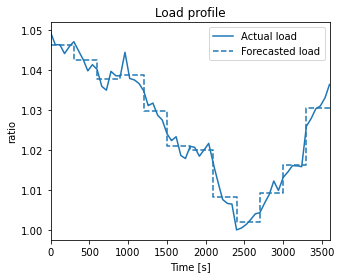

In [6]:
# --- get ANDES load ---
ptotal = ssa.PQ.as_df()['p0'].sum()
print('ANDES total load is:',ptotal.round(4),'p.u.')

# --- scale d_syn ---
ddata_path = '/case/d_syn2.csv'
ddata = dir_path + ddata_path
d_syn = pd.read_csv(ddata)

ratio = 10
# The equation is tuned for ieee39
# original: (d_syn['h10'] - d_syn['h10'].mean()) / d_syn['h10'].var() * ratio + 1
d_syn['s10'] = ratio*(d_syn['ph10'] - d_syn['ph10'].min()) / d_syn['h10'].var() + 1

# calculate expected load
step = 300
d_exp = d_syn.groupby(d_syn.index // step).mean().copy()
d_exp['time'] = range(0,3600,300)

fig_load, ax_load = plt.subplots(figsize=(5, 4))
ax_load.plot(d_syn['time'], d_syn['s10'], color='tab:blue', linestyle='-')
ystep = list(d_exp['s10'])
ystep.insert(0, d_exp['s10'].iloc[0])
ax_load.step(range(0,3900,300), ystep, color='tab:blue', linestyle='--')
ax_load.set_xlim([0, 3600])
ax_load.legend(['Actual load', 'Forecasted load'])
ax_load.set_title('Load profile')
ax_load.set_ylabel('ratio')
ax_load.set_xlabel('Time [s]')

## Setup ``ssp`` and ``ssd``

Convert ``ssa`` to pandapower net ``ssp``, add generator cost

The input cost array follow the matpower/pypower format, now only poly_cost is supported

In [7]:
# --- conversion ---
ssp = to_pandapower(ss0)

# set EV generator as uncontrollable
ssp.gen.controllable.iloc[9] = False

# add gen cost, G1-11. G10 EV, G11 Slack
linearcost = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1.5]

gen_cost = np.array([[2., 0., 0., 3., 0., 0., 0.]] * ssp.gen.shape[0])
gen_cost[:, 5] = linearcost  # c1

add_gencost(ssp, gen_cost)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0951 seconds.
0: |F(x)| = 7.561234474
1: |F(x)| = 2.917614383
2: |F(x)| = 0.1314910739
3: |F(x)| = 0.0003602307832
4: |F(x)| = 4.342665338e-09
Converged in 5 iterations in 0.0078 seconds.
Power flow results are consistent. Conversion is successful.


True

In [8]:
ssp.gen

,name,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,type,controllable,min_p_mw,max_p_mw,power_station_trafo
0,PV_1,29,436.086385,1.035534,100.0,-58.084,153.180,1.0,False,True,None,True,200.0,1500.0,NaN
1,PV_2,30,645.999998,1.013246,100.0,-122.665,429.804,1.0,False,True,None,True,150.0,900.0,NaN
2,PV_3,31,724.999998,1.020528,100.0,-180.218,446.722,1.0,False,True,None,True,100.0,800.0,NaN
3,PV_4,32,651.999998,1.013430,100.0,-213.780,548.208,1.0,False,True,None,True,100.0,700.0,NaN
4,PV_5,33,520.000000,1.019109,100.0,-188.028,611.495,1.0,False,True,None,True,100.0,700.0,NaN
5,PV_6,34,690.000000,1.060000,100.0,-234.972,593.788,1.0,False,True,None,True,100.0,800.0,NaN
6,PV_7,35,590.000000,1.060000,100.0,-249.132,568.372,1.0,False,True,None,True,100.0,700.0,NaN
7,PV_8,36,330.000000,1.013996,100.0,-216.122,443.468,1.0,False,True,None,True,100.0,700.0,NaN
8,PV_9,37,780.000000,1.052803,100.0,-356.889,834.775,1.0,False,True,None,True,100.0,1000.0,NaN
9,PV_10,37,-100.000000,1.052803,100.0,0.000,0.000,1.0,False,True,None,False,-120.0,90.0,NaN


Build RTED instance ``ssd``

In [9]:
ssd = rted3()
ssd.from_andes(ss0)

# set EV generator as uncontrollable
ssd.gen.ctrl.iloc[9] = 0

# set EV geenrator as type2
ssd.def_type2(['PV_10'], [0], [0])

# set ramp5
# ramp_hour = [999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999]
ramp_hour = [80, 80, 80, 50, 50, 50, 30, 30, 30, 999, 30]
ssd.gen.ramp5 = np.array(ramp_hour) * 10 / 12 / ssd.mva

# set cost
ssd.cost.c1 = linearcost

# update p_pre from DCOPF results
ssd.set_p_pre()

# sovle the model
ssd.get_res()

Restricted license - for non-production use only - expires 2023-10-25


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0064 seconds.
0: |F(x)| = 7.561234474
1: |F(x)| = 2.917614383
2: |F(x)| = 0.1314910739
3: |F(x)| = 0.0003602307832
4: |F(x)| = 4.342665338e-09
Converged in 5 iterations in 0.0078 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 69 rows, 11 columns and 597 nonzeros
Model fingerprint: 0x66000f8c
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 49 rows and 2 columns
Presolve time: 0.00s
Presolved: 20 rows, 18 columns, 175 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0064000e+01   9.050196e+01   0.000000e+00      0s
      16    6.0064000e+01   0.000000e+00   0.000000e+00      0s

Solved in 16 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.006400000e+01


Successfully solve DCOPF.
Successfully set p_pre from DCOPF results.
No RegUp cost data (``cru`` in ``cost``), set to 0.
No RegDn cost data(``crd`` in ``cost``), set to 0.
No RegUp requirement data (``du``), set to 0.
No RegDn requirement data (``dd``), set to 0.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0xd283ecc0
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+03, 2e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 113 rows and 25 columns
Presolve time: 0.00s
Presolved: 4 rows, 8 columns, 26 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0064000e+01   3.596043e+00   0.000000e+00      0s
       6    6.0064000e+01   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.006400000e+01


Successfully solve RTED.


,gen,pg,pru,prd,bu,bd
0,PV_1,13.138666,0.0,0.0,0.0,0.0
1,PV_2,5.882428,0.0,0.0,0.0,0.0
2,PV_3,5.540330,0.0,0.0,0.0,0.0
3,PV_4,7.000000,0.0,0.0,0.0,0.0
4,PV_5,6.583333,0.0,0.0,0.0,0.0
5,PV_6,5.216667,0.0,0.0,0.0,0.0
6,PV_7,4.980592,0.0,0.0,0.0,0.0
7,PV_8,6.971984,0.0,0.0,0.0,0.0
8,PV_9,1.250000,0.0,0.0,0.0,0.0
9,PV_10,-1.000000,0.0,0.0,0.0,0.0


Benchmark Standard DCOPF of ``ssd`` with ``ssp``

In [10]:
pp.rundcopp(ssp)
ppres = ssp.res_gen.copy()
ssdc = ssd.to_dcopf()
gb_res = ssdc.get_res()
ppres['p_mw(GB)'] = ssp.sn_mva * gb_res['pg'].values
print(f"pp cost={ssp.res_cost}, gb cost={ssd.res_cost}")
ppres

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 69 rows, 11 columns and 597 nonzeros
Model fingerprint: 0x66000f8c
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 49 rows and 2 columns
Presolve time: 0.00s
Presolved: 20 rows, 18 columns, 175 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0064000e+01   9.050196e+01   0.000000e+00      0s
      16    6.0064000e+01   0.000000e+00   0.000000e+00      0s

Solved in 16 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.006400000e+01


Successfully solve DCOPF.


pp cost=6006.400000338273, gb cost=60.06400000000576


,p_mw,q_mvar,va_degree,vm_pu,p_mw(GB)
0,977.365482,NaN,16.844264,1.0,1311.065021
1,689.503063,NaN,7.898144,1.0,654.909451
2,599.304318,NaN,9.172891,1.0,487.366320
3,527.808958,NaN,8.877479,1.0,700.000000
4,527.892957,NaN,8.501069,1.0,700.000000
5,601.701685,NaN,11.814799,1.0,480.000000
6,523.276851,NaN,14.677610,1.0,523.059208
7,433.574502,NaN,12.240939,1.0,700.000000
8,775.972181,NaN,12.421367,1.0,100.000000
9,-100.000000,NaN,12.421367,1.0,-100.000000


## Prepare

### Make link table

In [11]:
# --- link_table ---
ssa_key = make_link_table(ssa)

# --- add controllable in the link table ---
ssa_bus = ssa.Bus.as_df().reset_index().rename(columns={'uid':'bus_pp', 'idx':'bus_idx'})
ssp_gen = ssp.gen.reset_index().rename(columns={'index':'gen_pp', 'name':'stg_idx', 'controllable':'ctrl'})
ssa_key2 = pd.merge(left=ssa_key,
                    right=ssp_gen[['stg_idx', 'gen_pp', 'ctrl']],
                    on='stg_idx', how='left')

# --- device idx ---
ssa_dg_idx = ssa_key2.dg_idx.dropna().tolist()
ssa_syg_idx = ssa_key2.syg_idx.dropna().tolist()
ssa_gov_idx = ssa_key2.gov_idx.dropna().tolist()
ssa_stg_idx = ssa_key2.stg_idx.dropna().tolist()

# --- online and controllable device idx ---
ctrl_cond = ssa_key2.ctrl & ssa_key2.stg_u.astype(bool)
ssa_dg_idx_ctrl = ssa_key2.dg_idx[ctrl_cond].dropna().tolist()
ssa_syg_idx_ctrl = ssa_key2.syg_idx[ctrl_cond].dropna().tolist()
ssa_gov_idx_ctrl = ssa_key2.gov_idx[ctrl_cond].dropna().tolist()
ssa_stg_idx_ctrl = ssa_key2.stg_idx[ctrl_cond].dropna().tolist()

# fill NaN with False
ssa_key2.fillna(value=False, inplace=True)

ssa_key2

,stg_name,stg_u,stg_idx,bus_idx,dg_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq,gen_pp,ctrl
0,PV_1,1.0,PV_1,30,False,GENROU_1,IEEEX1_1,TGOV1_1,GEN30,1.0,1.0,0,True
1,PV_2,1.0,PV_2,31,False,GENROU_2,IEEEX1_2,TGOV1_2,GEN31,1.0,1.0,1,True
2,PV_3,1.0,PV_3,32,False,GENROU_3,IEEEX1_3,TGOV1_3,GEN32,1.0,1.0,2,True
3,PV_4,1.0,PV_4,33,False,GENROU_4,IEEEX1_4,TGOV1_4,GEN33,1.0,1.0,3,True
4,PV_5,1.0,PV_5,34,False,GENROU_5,IEEEX1_5,TGOV1_5,GEN34,1.0,1.0,4,True
5,PV_6,1.0,PV_6,35,False,GENROU_6,IEEEX1_6,TGOV1_6,GEN35,1.0,1.0,5,True
6,PV_7,1.0,PV_7,36,False,GENROU_7,IEEEX1_7,TGOV1_7,GEN36,1.0,1.0,6,True
7,PV_8,1.0,PV_8,37,False,GENROU_8,IEEEX1_8,TGOV1_8,GEN37,1.0,1.0,7,True
8,PV_9,1.0,PV_9,38,False,GENROU_9,IEEEX1_9,TGOV1_9,GEN38,1.0,1.0,8,True
9,Slack_10,1.0,Slack_10,39,False,GENROU_10,IEEEX1_10,TGOV1_10,GEN39,1.0,1.0,10,True


### Define functions used in loop

In [12]:
# --- def functions ---
def get_pe(ssa, gov_idx, dg_idx, ssa_key2):
    """Get the active power (TurbineGov/DG) after TDS, a DataFrame"""
    # TODO: may need to sum the power of same StaticGen
    # --- TurbineGov --- 
    pe_syg = ssa.TurbineGov.get(src='pout', idx=gov_idx, attr='v')
    # --- DG ---
    Ip_dg = ssa.DG.get(src='Ipout_y', idx=dg_idx, attr='v')
    v_dg = ssa.DG.get(src='v', idx=dg_idx, attr='v')
    pe_dg = Ip_dg*v_dg
    # --- out ---
    pe = pd.DataFrame()
    pe['idx'] = gov_idx + dg_idx
    pe['pe'] = np.concatenate((pe_syg, pe_dg))
    ldf = pd.merge(left=ssa_key2.rename(columns={'dg_idx':'idx'}),
         right=pe, how='right', on='idx')
    rdf = pd.merge(left=ssa_key2.rename(columns={'gov_idx':'idx'}),
             right=pe, how='right', on='idx')
    pe['stg_idx'] = ldf['stg_idx'].fillna('') + rdf['stg_idx'].fillna('')
    return pe

def dp_calc(d_syn, idx_ed, intv_ed):
    """Calc SFR requirements, scalars, ``dpd_u``and ``dpd_d``, and load forecasted value ``load_exp``"""
    load = d_syn['s10'].iloc[idx_ed*intv_ed:(idx_ed*intv_ed + intv_ed)]
    load_exp = load.mean()
    # TODO: check if the estimation is reasonable
    ratio = 50
    load_ci = stat.t.interval(alpha=0.95, df=len(load)-1, loc=np.mean(load), scale=stat.sem(load))
    load_d = abs(load_ci[0] - load_exp) * ratio
    load_u = abs(load_ci[1] - load_exp) * ratio
    return load_u, load_d, load_exp

## Define param

In [13]:
# --- constants ---
t_total = 3600    # 3600s

intv_ed = 300  # RTED interval, 300s
intv_agc = 4    # AGC interval, 4s
intv_pq = 1     # PQ interval, 1s; alter load and AGC
intv_step = 100 # step change interval; smooth the setpoitns

n_ed = int(t_total/intv_ed)
n_agc = int(intv_ed/intv_agc)
n_pq = int(intv_agc/intv_pq)
n_step = floor(intv_step/intv_agc)

# --- vars ---
# AGC table
agc_table = ssp.gen[['name']].rename(columns={'name':'stg_idx'})
agc_table['paux'] = 0
agc_res = agc_table[['stg_idx']].copy()

# ACE vars
ACE_integral = 0
ACE_raw = 0
Kp = 0.2 # 0.05
Ki = 0.05
ace_res = pd.DataFrame()

# initial load
ssa_p0 = ssa.PQ.p0.v.copy()
ssa_q0 = ssa.PQ.q0.v.copy()
ssa_pq_idx = ssa.PQ.idx.v
ssa_p0_sum = ssa_p0.sum()

## Loop

In the loop, there are mainly X parts:

- interval RTED: run DCOPF (``ssd.mdl``), run ACOPF(``ssp``), 

- interval AGC: do AGC, do dispatch with smooth setpoints

- interval PQ: alter load, run TDS(``ssa.TDS``)

Notes:

- The setpoints for DG are coded but not verified yet.

- After the development of ANDES control room, the dispatch and AGC part can be refactored.

- interface variables: ``DG.pmx``: DPV profile, ``DG.pref0``: setpoints, ``DG.pext0``: AGC

- ACOPF in pandapower considered generator limtis of ramping and SFR reserve

Check if RTED converge in all 12 intervals

In [14]:
# Reserve some capacity to avoid TDS crush
ssp.gen.max_p_mw = ssp.gen.max_p_mw * 1

# store original generator data
ssp_gen0 = ssp.gen.copy()

for end_time in range(400):  # t_total
    # --- interval RTED ---
    if end_time % intv_ed == 0:
        idx_ed = end_time // intv_ed
        # --- Load update ---
        du, dd, load_exp = dp_calc(d_syn, idx_ed, intv_ed)
        ssp.load['p_mw'] = ssa_p0 * load_exp * ssp.sn_mva
        ssp.load['q_mvar'] = ssa_q0 * load_exp * ssp.sn_mva
        ssd.load['p0'] = ssa_p0 * load_exp
        if end_time == 0:
            ssd.set_p_pre()
            p_pre = ssd.gen.p_pre
        ssd.gen.p_pre = p_pre

        # TODO: INPUT cost and ramp, ramp should be p.u.
        ssd.def_sfr(du=du*ssa_p0_sum, dd=dd*ssa_p0_sum)

        # build and solve the RTED-DC
        dcres = ssd.get_res()  # get RTED-DC resutls
        p_pre = dcres.pg
        # TODO: Integrate EV; send SFR back to EV

        print(f'RTED={idx_ed}')
        print(dcres)
        if dcres.pg.sum() == 0:
            logger.warning("Infeasible!")

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 69 rows, 11 columns and 597 nonzeros
Model fingerprint: 0x2c138b9f
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 49 rows and 2 columns
Presolve time: 0.00s
Presolved: 20 rows, 18 columns, 175 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2770283e+01   9.362117e+01   0.000000e+00      0s
      19    6.2770283e+01   0.000000e+00   0.000000e+00      0s

Solved in 19 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.277028348e+01


Successfully solve DCOPF.
Successfully set p_pre from DCOPF results.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x1dced058
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+03, 2e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 103 rows and 14 columns
Presolve time: 0.00s
Presolved: 14 rows, 19 columns, 57 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2770283e+01   2.752616e+00   0.000000e+00      0s
      15    6.2770283e+01   0.000000e+00   0.000000e+00      0s

Solved in 15 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.277028348e+01


Successfully solve RTED.


RTED=0
         gen         pg      pru      prd   bu       bd
0       PV_1  11.695356  0.00000  0.00000  0.0  0.00000
1       PV_2   8.314721  0.00000  0.14697  0.0  0.37023
2       PV_3   7.394054  0.00000  0.00000  0.0  0.00000
3       PV_4   7.000000  0.00000  0.00000  0.0  0.00000
4       PV_5   6.583333  0.39697  0.00000  1.0  0.00000
5       PV_6   5.216667  0.00000  0.00000  0.0  0.00000
6       PV_7   4.980592  0.00000  0.00000  0.0  0.00000
7       PV_8   6.835561  0.00000  0.00000  0.0  0.00000
8       PV_9   1.250000  0.00000  0.25000  0.0  0.62977
9      PV_10  -1.000000  0.00000  0.00000  0.0  0.00000
10  Slack_10   3.000000  0.00000  0.00000  0.0  0.00000
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x033538ec
Coefficient statis

Successfully solve RTED.


RTED=1
         gen         pg      pru      prd   bu   bd
0       PV_1  12.362022  0.00000  0.00000  0.0  0.0
1       PV_2   7.932193  0.00000  0.72806  0.0  1.0
2       PV_3   6.727387  0.00000  0.00000  0.0  0.0
3       PV_4   7.000000  0.00000  0.00000  0.0  0.0
4       PV_5   6.166667  0.72806  0.00000  1.0  0.0
5       PV_6   5.633333  0.00000  0.00000  0.0  0.0
6       PV_7   5.230592  0.00000  0.00000  0.0  0.0
7       PV_8   7.000000  0.00000  0.00000  0.0  0.0
8       PV_9   1.000000  0.00000  0.00000  0.0  0.0
9      PV_10  -1.000000  0.00000  0.00000  0.0  0.0
10  Slack_10   3.000000  0.00000  0.00000  0.0  0.0


In [ ]:
# Reserve some capacity to avoid TDS crush
ssp.gen.max_p_mw = ssp.gen.max_p_mw * 1

# store original generator data
ssp_gen0 = ssp.gen.copy()

for end_time in range(t_total): # t_total
    # --- interval RTED ---
    if end_time % intv_ed == 0:
        idx_ed = end_time // intv_ed
        # --- Load update ---
        du, dd, load_exp = dp_calc(d_syn, idx_ed, intv_ed)
        ssp.load['p_mw'] = ssa_p0 * ssp.sn_mva * load_exp
        ssp.load['q_mvar'] = ssa_q0 * ssp.sn_mva * load_exp
        ssd.load['p0'] = ssa_p0 * load_exp
        ssd.update_dict()

        # --- RTED, update gen limits after SFR ---
        if end_time > 0:
            # get pe from TDS and sort
            pe_tds = get_pe(ssa, ssa_gov_idx, ssa_dg_idx, ssa_key2)
            pe_tds = pe_tds.merge(ssa_key2,
                                 on='stg_idx', how='right').groupby('stg_idx', as_index=False).sum()
            p_pre = pe_tds
            ssd.gen.p_pre = pd.merge(left=ssd.gen, how='left', on='idx',
                         right=pe_tds[['stg_idx', 'pe']].rename(columns={'stg_idx': 'idx'}))['pe']
        else:
            # DCOPF results as the initial previous setpoints
            ssd.set_p_pre()
            p_pre = ssd.gen[['idx', 'p_pre']].rename(columns={'p_pre':'pe', 'idx':'stg_idx'})

        # def sfr requirements and ev sfr limtis (p.u.)
        # TODO: Integrate EV; EV limits FROM EV; now set 0 to disable EV SFR
        ssd.def_sfr(du=du*ssa_p0_sum, dd=dd*ssa_p0_sum)

        # build and solve the RTED-DC
        dcres = ssd.get_res()  # get RTED-DC resutls
        # TODO: Integrate EV; send SFR back to EV

        # Reserve SFR and ramp from Generator limits in ``ssp``
        ssp_gen = pd.merge(left=ssp.gen.rename(columns={'name':'stg_idx'}),
                           right=dcres.rename(columns={'gen':'stg_idx'}),
                           on='stg_idx', how='left')
        # SFR limits
        ssp_gen['max_sfr'] = ssp_gen.max_p_mw - ssp_gen.pru * ssp.sn_mva
        ssp_gen['min_sfr'] = ssp_gen.min_p_mw + ssp_gen.prd * ssp.sn_mva
        # ramp limits
        p_pre_pp = pd.merge(left=ssp.gen.rename(columns={'name': 'stg_idx'}),
                            right=p_pre[['stg_idx', 'pe']],
                            on='stg_idx', how='left')['pe']
        ssp_gen['max_ramp'] = ssp.sn_mva * (np.array(p_pre_pp) + np.array(ssd.gen.ramp5))
        ssp_gen['min_ramp'] = ssp.sn_mva * (np.array(p_pre_pp) - np.array(ssd.gen.ramp5))
        # alter generator limits
        ssp.gen.max_p_mw = ssp_gen[['max_sfr','max_ramp']].min(axis=1)
        ssp.gen.min_p_mw = ssp_gen[['min_sfr','min_ramp']].max(axis=1)

        # --- ACOPF, update setpoints ---
        # store setpoints
        if end_time > 0:
            p0 = ssp_res['p'].values  # store setpoints
        else:
            p0 = [0] * ssa_key2.shape[0]

        # run ACOPF
        ssp_res = runopp_map(ssp, ssa_key)  # ACOPF resutls
        ssp_res['p0'] = p0                  # last setpoints
        ssp_res.fillna(False, inplace=True) # Fill NA wil False

        # reset Generator limtis
        ssp.gen.max_p_mw = ssp_gen0.max_p_mw
        ssp.gen.min_p_mw = ssp_gen0.min_p_mw

    # --- interval AGC ---
    ace_gain = 1
    if end_time % intv_agc == 0:
        idx_agc = end_time // intv_agc - idx_ed * n_agc
        # --- AGC allocation, with a power cap ---
        ACE_input = min(ACE_raw, dcres.pru.sum())
        if ACE_raw >= 0:
            ACE_input = min(ACE_raw, dcres.pru.sum())
            agc_table['paux'] = ACE_input * ace_gain * dcres.bu.values
        else:
            ACE_input = max(ACE_raw, -1 * dcres.prd.sum())
            agc_table['paux'] = ACE_input * ace_gain * dcres.bd.values
        agc_res[f'{end_time}'] = agc_table['paux']
        ace_data = [end_time, ACE_raw, dcres.pru.sum(),
                    -1*dcres.prd.sum(), ACE_input]
        ace_new = pd.DataFrame([ace_data], columns=['time', 'ace', 'up', 'dn', 'in'])
        ace_res = pd.concat([ace_res, ace_new])

        # --- Do AGC ---
        # a.SynGen
        agc_syg = pd.merge(left=agc_table,
                           right=ssa_key2,
                           on='stg_idx', how='right')
        agc_syg['paux2'] = agc_syg.paux * agc_syg.gammap
        cond_gov = agc_syg.ctrl * agc_syg.gov_idx.astype(bool)
        agc_gov = agc_syg.gov_idx[cond_gov].tolist()
        ssa.TurbineGov.set(src='paux0', idx=agc_gov, attr='v',
                           value=agc_syg.paux2.values)
        # b.DG
        agc_dg = pd.merge(left=agc_table,
                          right=ssa_key2,
                          on='stg_idx', how='right')
        agc_dg['paux2'] = agc_dg.paux * agc_dg.gammap
        cond_dg = agc_dg.ctrl * agc_dg.dg_idx.astype(bool)
        agc_dg_idx = agc_dg.dg_idx[cond_dg].tolist()
        ssa.DG.set(src='pext0', idx=agc_dg_idx, attr='v',
                           value=agc_dg.paux2.values)
        
        # --- smooth setpoints ---
        if idx_ed == 0:
            ssp_res['pref'] = ssp_res['p']
        else:
            print("SMOOTH")
            if idx_agc == 0:
                # only record the pe from TDS in the first AGC interval
                copy = ssp_res.merge(right=pe_tds[['pe', 'stg_idx']], on='stg_idx', how='left')
                ssp_res['pe_tds'] = copy.pe
            idx_step = min((end_time - idx_ed * intv_ed) // intv_agc + 1, n_step)
            ssp_res['pref_step'] = ssp_res.p - ssp_res.pe_tds
            # smooth change threshold: 0.1
            large_index = ssp_res['pref_step'][abs(ssp_res['pref_step']) > 0.01].index
            ssp_res['pref_delta'] = ssp_res['pref_step']
            ssp_res['pref_delta'].iloc[large_index] = ssp_res['pref_step'].iloc[large_index] / n_step * idx_step
            ssp_res['pref'] = ssp_res.pe_tds + ssp_res.pref_delta

            # update SynGen setpoints
            cond_gov = ssp_res.controllable & ssp_res.gov_idx.astype(bool)
            ssa.TurbineGov.set(src='pref0', idx=ssp_res.gov_idx[cond_gov].tolist(),
                               attr='v', value=ssp_res.pref[cond_gov].values)
            # update DG setpoints
            cond_dg = ssp_res.controllable & ssp_res.dg_idx.astype(bool)
            ssa.DG.set(src='pref0', idx=ssp_res.dg_idx[cond_dg].tolist(),
                       attr='v', value=ssp_res.pref[cond_dg].values)

    # --- intv_pq: alter load, run TDS ---
    if end_time == 0:
        # Initially, alter StaticGen: p0 and q0, RUN power flow
        stg_opf_idx = ssp_res.stg_idx[ssp_res.controllable].tolist()
        stg_opf_val = ssp_res.p[ssp_res.controllable].tolist()
        stg_opf_v = ssp_res.vm_pu[ssp_res.controllable].tolist()
        ssa.StaticGen.set(src='p0', idx=stg_opf_idx, attr='v', value=stg_opf_val)
        ssa.StaticGen.set(src='v0', idx=stg_opf_idx, attr='v', value=stg_opf_v)
        ssa.PQ.set(src='p0', idx=ssa_pq_idx, attr='v',
                   value=ssa_p0 * load_exp)
        ssa.PQ.set(src='q0', idx=ssa_pq_idx, attr='v',
                   value=ssa_q0 * load_exp)
        ssa.PFlow.run()
    else:
        # Otherwise, alter Ppf and Qpf
        ssa.PQ.set(src='Ppf', idx=ssa_pq_idx, attr='v',
                    value=ssa_p0 * d_syn['s10'].iloc[end_time])
        ssa.PQ.set(src='Qpf', idx=ssa_pq_idx, attr='v',
                    value=ssa_q0 * d_syn['s10'].iloc[end_time])
        
    # RUN TDS
    ssa.TDS.config.tf = end_time
    if not end_time == 0:
        ssa.TDS.run()
    # ACE calculation
    ACE_integral = ACE_integral + ssa.ACEc.ace.v.sum()
    ACE_raw = -(Kp*ssa.ACEc.ace.v.sum() + Ki*ACE_integral)

    # ACE_raw = 0  # delete when run TDS
    # break loop if TDS run into error
    if ssa.exit_code != 0:
        raise ValueError(f"TDS error! Exit with {ssa.exit_code}, end at {end_time}s.")

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 69 rows, 11 columns and 597 nonzeros
Model fingerprint: 0x2c138b9f
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 49 rows and 2 columns
Presolve time: 0.00s
Presolved: 20 rows, 18 columns, 175 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2770283e+01   9.362117e+01   0.000000e+00      0s
      19    6.2770283e+01   0.000000e+00   0.000000e+00      0s

Solved in 19 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.277028348e+01


Successfully solve DCOPF.
Successfully set p_pre from DCOPF results.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x1dced058
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+03, 2e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 103 rows and 14 columns
Presolve time: 0.00s
Presolved: 14 rows, 19 columns, 57 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2770283e+01   2.752616e+00   0.000000e+00      0s
      15    6.2770283e+01   0.000000e+00   0.000000e+00      0s

Solved in 15 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.277028348e+01


Successfully solve RTED.
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0591 seconds.
0: |F(x)| = 8.353382961
1: |F(x)| = 3.708268688
2: |F(x)| = 0.2223496893
3: |F(x)| = 0.001149595906
4: |F(x)| = 6.240362094e-08
Converged in 5 iterations in 0.0079 seconds.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-1 s.
Fixed step size: h=33.33 ms. Shrink if not converged.
Numba compilation initiated with

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0382 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1036 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1123 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1263 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1265 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1175 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1080 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0927 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0843 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1103 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1230 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1262 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1257 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1107 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1038 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1157 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1162 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1049 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1087 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1233 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1281 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1047 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1104 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1234 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0907 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0923 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0762 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0642 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0623 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0625 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0638 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0812 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0628 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0629 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0623 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0628 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0630 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0627 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0626 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0625 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0624 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0624 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0623 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0630 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0625 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0625 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0854 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0793 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0915 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0813 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0919 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0942 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0992 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0759 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0916 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0917 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0955 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0848 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0922 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0920 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0904 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0837 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0910 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0919 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0899 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0832 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0908 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0917 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0902 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0833 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0912 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0917 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0902 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0831 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0xd0ddca7c
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+03, 2e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 103 rows and 14 columns
Presolve time: 0.00s
Presolved: 14 rows, 19 columns, 57 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2552195e+01   3.025011e+00   0.000000e+00      0s
      15    6.2552195e+01   0.000000e+00   0.000000e+00      0s

Solved in 15 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.255219463e+01


Successfully solve RTED.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0629 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0624 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0628 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0621 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0626 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0646 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0626 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0621 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0624 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0628 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0630 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0623 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0627 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0626 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0630 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0632 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0647 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0629 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0625 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0628 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0633 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0624 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0629 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0628 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0627 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0625 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0630 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0628 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0629 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0627 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0628 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0625 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0630 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0627 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0632 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0632 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0626 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0633 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0628 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0630 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0625 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0628 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0627 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0628 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0636 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0627 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0623 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0627 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0628 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0627 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0630 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0632 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0762 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0636 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0629 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0625 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0778 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0639 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0629 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0626 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0779 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0637 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0626 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0627 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0776 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0645 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0626 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0627 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0776 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0644 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0627 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0624 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0785 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0645 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0625 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0626 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0785 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0644 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0648 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0626 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0809 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0629 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0628 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0624 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0621 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0626 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0629 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0628 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0627 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0622 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0625 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0625 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0623 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0624 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0629 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0627 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0627 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0622 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0628 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0626 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0624 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0627 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0629 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0626 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0625 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0627 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0633 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0631 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0625 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0625 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0629 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0790 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0633 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0638 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0636 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0640 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0641 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0639 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0644 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0639 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0638 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0638 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0638 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0639 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0641 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0639 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0646 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0639 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0637 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0643 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0639 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0637 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0638 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0643 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0637 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0635 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0634 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0639 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0637 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0635 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0636 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0637 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0634 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0636 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0634 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0639 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0636 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0635 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0636 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0634 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0638 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0635 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0639 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0635 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0641 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0636 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0643 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0635 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0633 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0641 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0642 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0637 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0637 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0637 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0640 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0635 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0637 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0643 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0647 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0643 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0646 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0781 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0624 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0624 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0627 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0632 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0629 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0624 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0626 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0630 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0627 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0627 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0627 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0629 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0623 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0626 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0625 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0628 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0721 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0628 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0626 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0628 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0839 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0764 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x0d09648b
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+03, 2e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 89 rows and 3 columns
Presolve time: 0.00s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Infeasible model


RTED has no valid resutls!


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0859 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0721 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0769 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0795 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0813 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0823 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0721 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0819 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0780 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0766 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0770 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0770 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0804 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0805 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0822 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0773 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0646 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0764 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0648 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0647 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0648 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0647 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0647 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0643 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0647 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0647 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0648 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0793 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


SMOOTH


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0646 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0648 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


SMOOTH


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


SMOOTH


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0648 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0648 seconds.
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


SMOOTH


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0648 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0647 seconds.
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


SMOOTH


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0647 seconds.
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


SMOOTH


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


SMOOTH


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0775 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0794 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0648 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0648 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0646 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0645 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0646 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0782 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0647 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0642 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0636 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0641 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0636 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0636 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0638 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0xfd0a3951
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+03, 2e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 90 rows and 3 columns
Presolve time: 0.00s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Infeasible model


RTED has no valid resutls!


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0833 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0647 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0646 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0648 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0648 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0721 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0645 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0748 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0646 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0646 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0648 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0644 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0748 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0648 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0755 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0646 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0764 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0765 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0800 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0636 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0641 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0637 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0642 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0639 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0635 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0641 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0645 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0640 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0639 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0637 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0646 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0645 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0645 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0742 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0647 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0648 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0760 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0759 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0640 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0637 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0640 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0635 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0639 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0639 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0639 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0640 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0636 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0642 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0635 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0639 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0637 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0642 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0637 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0639 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0637 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0644 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0644 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0639 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0644 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0642 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0643 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0639 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0643 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0641 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0641 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0642 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0642 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0639 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0641 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0644 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0642 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0641 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0643 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0639 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0648 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0648 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0831 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0888 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0799 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0797 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0797 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0802 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0855 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0819 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0805 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0897 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0910 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0789 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0825 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0xf1363971
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+03, 2e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 90 rows and 3 columns
Presolve time: 0.00s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Infeasible model


RTED has no valid resutls!


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0907 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0748 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0952 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0830 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0873 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0915 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0748 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0726 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0810 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0774 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0778 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0785 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0744 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0778 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0742 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0794 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x61ce5ed7
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+03, 2e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 90 rows and 3 columns
Presolve time: 0.00s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Infeasible model


RTED has no valid resutls!


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0776 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0745 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0802 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0763 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0804 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0833 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0954 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0738 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0849 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0833 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0841 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x13ea7841
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+03, 2e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 91 rows and 3 columns
Presolve time: 0.00s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Infeasible model


RTED has no valid resutls!


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0889 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0739 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0827 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0850 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0734 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0821 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0728 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0812 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0xe5e6ff37
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+03, 2e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 91 rows and 3 columns
Presolve time: 0.00s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Infeasible model


RTED has no valid resutls!


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0773 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0762 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0730 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0782 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x3f8543ef
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+03, 2e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 92 rows and 3 columns
Presolve time: 0.00s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Infeasible model


RTED has no valid resutls!


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0856 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0822 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0798 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0808 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0780 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0644 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0808 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x157235cd
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+03, 2e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 92 rows and 3 columns
Presolve time: 0.01s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Infeasible model


RTED has no valid resutls!


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0939 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0763 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0839 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0854 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0819 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0820 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0728 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0802 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0812 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0739 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0798 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0884 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0739 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0753 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0828 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0759 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0752 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0761 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0796 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0805 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0821 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0790 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0798 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0819 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0803 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0824 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0803 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0728 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0811 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0813 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x5b4aaa72
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+03, 2e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 92 rows and 3 columns
Presolve time: 0.00s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Infeasible model


RTED has no valid resutls!


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0922 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0947 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0816 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0820 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0818 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x3a59baeb
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+03, 2e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 92 rows and 3 columns
Presolve time: 0.00s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Infeasible model


RTED has no valid resutls!


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0964 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0924 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0872 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0760 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0838 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0803 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


SMOOTH


/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


In [ ]:
# color=['tab:blue', 'tab:orange', 'tab:green',
#        'tab:red', 'tab:purple']
right=end_time

fig_gen, ax_gen = plt.subplots(2, 3, figsize=(16, 8))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.3, hspace=0.6)

yheader = [f'G{i}' for i in range(1,11)]

ssa.TDS.plt.plot(ssa.TGOV1N.pout,
                 linestyles=['-'],
                   yheader=yheader,
                   legend=True, show=False, right=right,
                   title=r'Generation (solid: pout; dash: pref)',
                   ylabel='p.u.',
                   fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.pref,
                 legend=False, show=False, right=right,
                   linestyles=['--'],
                   fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.paux,
                linestyles=['-'],
                yheader=yheader,
                legend=False, show=False, right=right,
                title=r'AGC power',
                ylabel='p.u.',
                fig=fig_gen, ax=ax_gen[0, 1])

ace_res.plot(linewidth=1,
            fig=fig_gen, ax=ax_gen[0, 2],
            x='time', y='ace',
            title=f'AGC input and SFR capacity')
ace_res.plot(linewidth=1,
            fig=fig_gen, ax=ax_gen[0, 2],
            x='time', y='in',)
ace_res.plot(linewidth=1, color='k', linestyle='--',
            fig=fig_gen, ax=ax_gen[0, 2],
            x='time', y='up')
ace_res.plot(linewidth=1, color='k', linestyle='--',
            fig=fig_gen, ax=ax_gen[0, 2],
            x='time', y='dn')
ax_gen[0, 2].set_ylabel('p.u.')
ax_gen[0, 2].legend(['ACE raw', 'AGC input', 'SFR capacity'])

ssa.TDS.plt.plot(ssa.COI.omega,
                 legend=False, show=False, right=right,
                 linestyles=['-'],
                 ytimes=60,
                 title=r'COI Frequency',
                 ylabel='Hz',
                 fig=fig_gen, ax=ax_gen[1, 0])

ssa.TDS.plt.plot(ssa.ACEc.ace,
                 legend=False, show=False, right=right,
                 linestyles=['-'],
                 title=r'ACE',
                 ylabel='p.u.',
                 fig=fig_gen, ax=ax_gen[1, 1])

font = {'family' : 'TimesNewRoma',
        'weight' : '1',
        'size'   : 12}

plt.rc('font', **font)

ace_tds = ssa.dae.ts.y[:, ssa.ACEc.ace.a].reshape(-1).copy()
ace_df = pd.DataFrame()
ace_df['ace'] = ace_tds
ace_df.plot(kind='kde', legend=False, linewidth=1,
            fig=fig_gen, ax=ax_gen[1, 2],
            title=f'ACE Density, mean={ace_df.ace.mean().round(4)}')
ax_gen[1, 2].set(xlabel='Deviation [p.u.]', ylabel='')